# DATA CLEANING

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# -----------------------------------------
# 1. Load dataset (cache data)
# -----------------------------------------
def load_data():
    df = pd.read_csv("coba-data.csv")   # ganti dengan dataset UKT kamu
    return df

df = load_data()

### Menampilkan Ringkasan Struktur DataFrame (df)

In [ ]:
#
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18742 entries, 0 to 18741
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   nama                   18742 non-null  int64  
 1   jenjang                18742 non-null  object 
 2   prodi                  18742 non-null  object 
 3   ayah_meninggal         18742 non-null  int64  
 4   ibu_meninggal          18742 non-null  int64  
 5   id_pekerjaan_ayah      17593 non-null  float64
 6   id_pekerjaan_ibu       18233 non-null  float64
 7   sumber_listrik         18742 non-null  object 
 8   luas_tanah             18742 non-null  object 
 9   bahan_atap             18742 non-null  object 
 10  bahan_lantai           18742 non-null  object 
 11  bahan_tembok           18742 non-null  object 
 12  mck                    18742 non-null  object 
 13  sumber_air             18742 non-null  object 
 14  rencana_tinggal        18742 non-null  object 
 15  tr


### DROP KOLOM NAMA

In [ ]:
df = df.drop(columns=['nama'])

### Membuat salinan independen dari DataFrame df.

Hasilnya disimpan ke variabel baru df_clean.

Tujuannya:

Supaya data asli (df) tetap aman dan tidak berubah.

Semua proses pembersihan data (data cleaning) dilakukan di df_clean.

Jika terjadi kesalahan saat preprocessing, data asli masih bisa digunakan kembali.

In [ ]:
import pandas as pd
import numpy as np

df_clean = df.copy()




### Mengecek apakah kolom nama ada. Jika ada, maka kolom tersebut dihapus agar tidak ikut diproses dalam analisis.



In [ ]:
if 'nama' in df_clean.columns:
    df_clean = df_clean.drop(columns=['nama'])




### Mengecek tipe data tiap kolom dan Mengidentifikasi jumlah dan distribusi missing values.

In [ ]:
print(df_clean.dtypes)
print(df_clean.isna().sum().sort_values(ascending=False))

jenjang                   object
prodi                     object
ayah_meninggal             int64
ibu_meninggal              int64
id_pekerjaan_ayah        float64
id_pekerjaan_ibu         float64
sumber_listrik            object
luas_tanah                object
bahan_atap                object
bahan_lantai              object
bahan_tembok              object
mck                       object
sumber_air                object
rencana_tinggal           object
transportasi_asal         object
transportasi_sekarang     object
milik_rumah               object
daya_listrik               int64
jumlah_tanggungan          int64
jarak_pusat_kota           int64
penghasilan_ayah         float64
penghasilan_ibu          float64
dtype: object
id_pekerjaan_ayah        1149
penghasilan_ayah         1149
penghasilan_ibu           509
id_pekerjaan_ibu          509
prodi                       0
jenjang                     0
ayah_meninggal              0
ibu_meninggal               0
sumber_listrik      

**KESIMPULAN DARI HASIL DI ATAS**


*   Dataset terdiri dari campuran data kategorikal dan numerik.

*   Ada missing values besar pada variabel pekerjaan dan penghasilan orang tua.

*   Informasi ini penting untuk menentukan strategi preprocessing:

*   Encoding untuk variabel kategorikal.

*   Imputasi untuk variabel dengan missing values.

*   Standarisasi untuk variabel numerik sebelum PCA/KMeans.

### Pembersihan dan standarisasi kolom luas_tanah



*   Mengubah data teks menjadi angka float yang konsisten.

*   Menangani kasus range dengan rata-rata.

*   Mengisi nilai kosong dengan median agar tidak ada missing values.




In [ ]:
import re
import numpy as np
import pandas as pd

def parse_luas_tanah(val):
    if pd.isna(val):
        return np.nan
    s = str(val).strip().lower()

    # Normalisasi pemisah ribuan/desimal yang umum
    s = s.replace(',', '.')  # seragamkan koma ke titik
    s = re.sub(r'[^0-9\.\-]', ' ', s)  # sisakan angka, titik, minus sebagai pemisah
    s = re.sub(r'\s+', ' ', s).strip()

    # Ambil semua angka (integer/float) dalam string
    nums = re.findall(r'\d+(?:\.\d+)?', s)

    if len(nums) == 0:
        return np.nan
    elif len(nums) == 1:
        try:
            return float(nums[0])
        except ValueError:
            return np.nan
    elif len(nums) == 2:
        # Asumsikan range: ambil rata-rata
        try:
            a, b = float(nums[0]), float(nums[1])
            # Jika jelas bukan range (mis. 100 dan 2002), ambil angka pertama yang lebih kecil
            if b >= 10 * a:  # heuristik: selisih terlalu besar → bukan range
                return a
            return (a + b) / 2.0
        except ValueError:
            return np.nan
    else:
        # Terlalu banyak angka → ambil angka pertama yang paling kecil sebagai proxy
        try:
            floats = [float(x) for x in nums]
            return min(floats)
        except ValueError:
            return np.nan

# Terapkan ke kolom luas_tanah
if 'luas_tanah' in df_clean.columns:
    df_clean['luas_tanah_parsed'] = df_clean['luas_tanah'].apply(parse_luas_tanah)

    # Jika ingin mengganti kolom asli:
    df_clean['luas_tanah'] = df_clean['luas_tanah_parsed']
    df_clean = df_clean.drop(columns=['luas_tanah_parsed'])

    # Imputasi median untuk nilai yang masih NaN
    median_val = df_clean['luas_tanah'].median()
    df_clean['luas_tanah'] = df_clean['luas_tanah'].fillna(median_val)


🔽 Mengeksplorasi distribusi data numerik (luas tanah) dan mengecek jumlah data kosong yang tersisa.

In [ ]:
print(df_clean['luas_tanah'].describe())
print(df_clean['luas_tanah'].isna().sum())


count    18742.000000
mean        25.743624
std         39.962365
min          2.000000
25%          2.000000
50%          2.000000
75%         13.500000
max        101.000000
Name: luas_tanah, dtype: float64
0


🔽 Membandingkan data mentah dengan hasil pembersihan pada kolom luas_tanah

In [ ]:
sample_idx = df.sample(10, random_state=42).index
print(pd.DataFrame({
    'raw': df.loc[sample_idx, 'luas_tanah'],
    'parsed': df_clean.loc[sample_idx, 'luas_tanah']
}))


                raw  parsed
5860   100 - 200 m2     2.0
4724     25 - 50 m2     2.0
16936       < 25 m2    13.5
13730  100 - 200 m2     2.0
3458        < 25 m2    13.5
4863       > 200 m2   101.0
8116     50 - 99 m2     2.0
10952    50 - 99 m2     2.0
11243       < 25 m2    13.5
16439       < 25 m2    13.5


🔼 Fungsi parse_luas_tanah berhasil mengubah teks menjadi angka, tapi hasilnya belum konsisten:

* Range seperti "100 - 200 m2" tidak diproses sebagai rata-rata (150.0), malah jadi angka kecil (2.0).

* Simbol < atau > menyebabkan hasil ambigu, lalu median imputasi dipakai.

* Artinya, parsing ini butuh perbaikan regex/heuristik agar lebih sesuai dengan makna asli data.

In [ ]:
def map_luas_tanah_kategori(val):
    if pd.isna(val):
        return np.nan
    s = str(val).strip().lower()

    # Mapping eksplisit berdasarkan kategori umum
    if '<' in s or 'kurang dari' in s:
        return 13.5  # representasi rata-rata <25
    elif '25 - 50' in s:
        return 37.5
    elif '50 - 99' in s:
        return 74.5
    elif '100 - 200' in s:
        return 150.0
    elif '200' in s and '>' in s:
        return 250.0
    elif 'm2' in s:
        # fallback: ambil angka pertama
        import re
        nums = re.findall(r'\d+(?:\.\d+)?', s)
        if nums:
            return float(nums[0])
    return np.nan

# Terapkan ke kolom luas_tanah
df_clean['luas_tanah'] = df['luas_tanah'].apply(map_luas_tanah_kategori)

# Imputasi median jika masih ada NaN
median_val = df_clean['luas_tanah'].median()
df_clean['luas_tanah'] = df_clean['luas_tanah'].fillna(median_val)


In [ ]:
print(df_clean['luas_tanah'].describe())


count    18742.000000
mean       120.958569
std         85.407787
min         13.500000
25%         37.500000
50%        150.000000
75%        150.000000
max        250.000000
Name: luas_tanah, dtype: float64


In [ ]:
print(df_clean['luas_tanah'].isna().sum())


0


In [ ]:
sample_idx = df.sample(10, random_state=42).index
print(pd.DataFrame({
    'raw': df.loc[sample_idx, 'luas_tanah'],
    'parsed': df_clean.loc[sample_idx, 'luas_tanah']
}))


                raw  parsed
5860   100 - 200 m2   150.0
4724     25 - 50 m2    37.5
16936       < 25 m2    13.5
13730  100 - 200 m2   150.0
3458        < 25 m2    13.5
4863       > 200 m2   250.0
8116     50 - 99 m2    74.5
10952    50 - 99 m2    74.5
11243       < 25 m2    13.5
16439       < 25 m2    13.5


In [ ]:
print(df_clean['luas_tanah'].value_counts())


luas_tanah
150.0    6109
250.0    4084
13.5     3538
74.5     2540
37.5     2471
Name: count, dtype: int64


### Mengecek tipe data untuk menentukan apakah perlu encoding dan missing values untuk menentukan apakah perlu imputasi (mengganti nilai kosong seperti mean atau median)

In [ ]:
print(df_clean.dtypes)
print(df_clean.isna().sum().sort_values(ascending=False))


jenjang                   object
prodi                     object
ayah_meninggal             int64
ibu_meninggal              int64
id_pekerjaan_ayah        float64
id_pekerjaan_ibu         float64
sumber_listrik            object
luas_tanah               float64
bahan_atap                object
bahan_lantai              object
bahan_tembok              object
mck                       object
sumber_air                object
rencana_tinggal           object
transportasi_asal         object
transportasi_sekarang     object
milik_rumah               object
daya_listrik               int64
jumlah_tanggungan          int64
jarak_pusat_kota           int64
penghasilan_ayah         float64
penghasilan_ibu          float64
dtype: object
id_pekerjaan_ayah        1149
penghasilan_ayah         1149
penghasilan_ibu           509
id_pekerjaan_ibu          509
prodi                       0
jenjang                     0
ayah_meninggal              0
ibu_meninggal               0
sumber_listrik      



---



### Imputasi Median untuk Kolom PENGHASILAN Dan PEKERJAAN

IMPUTASI KOLOM MEDIAN PENGHASILAN


*   Tujuan: Mengisi nilai kosong (NaN) pada kolom penghasilan_ayah dan penghasilan_ibu.

*   Metode: Menggunakan median dari masing-masing kolom.

*   Alasan: Median lebih tahan terhadap outlier dibanding mean. Jadi kalau ada penghasilan ekstrem (misalnya sangat tinggi), median tetap representatif.


IMPUTASI MODE UNTUK KOLOM PEKERJAAN

* Tujuan: Mengisi nilai kosong (NaN) pada kolom id_pekerjaan_ayah dan id_pekerjaan_ibu.

* Metode: Menggunakan mode (nilai yang paling sering muncul).

*  Alasan: Karena id_pekerjaan adalah data kategorikal (ID pekerjaan), maka mode adalah pilihan logis untuk mengganti nilai hilang dengan kategori paling umum.

In [ ]:
# Imputasi median untuk penghasilan
for col in ['penghasilan_ayah','penghasilan_ibu']:
    df_clean[col] = df_clean[col].fillna(df_clean[col].median())

# Imputasi mode untuk id_pekerjaan
for col in ['id_pekerjaan_ayah','id_pekerjaan_ibu']:
    df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0])




---



###  Mengecek kolom yang perlu imputasi atau pembersihan.

In [ ]:
print(df_clean.isna().sum().sort_values(ascending=False).head())


jenjang              0
prodi                0
ayah_meninggal       0
ibu_meninggal        0
id_pekerjaan_ayah    0
dtype: int64


Kolom-kolom yang ditampilkan sudah bersih dari NaN.



---



### MENGECEK Apakah data numerik sudah bersih dan terdistribusi wajar, dan Apakah data kategorikal punya kategori dominan atau perlu encoding.

In [ ]:
print(df_clean.describe())
for c in df_clean.select_dtypes(exclude=['number']).columns:
    print(f"\nKolom: {c}")
    print(df_clean[c].value_counts().head(5))


       ayah_meninggal  ibu_meninggal  id_pekerjaan_ayah  id_pekerjaan_ibu  \
count    18742.000000   18742.000000       18742.000000      18742.000000   
mean         0.091132       0.043272          13.459396         20.921833   
std          0.287805       0.203474          23.102265         27.888981   
min          0.000000       0.000000           2.000000          2.000000   
25%          0.000000       0.000000           5.000000          7.000000   
50%          0.000000       0.000000           7.000000         15.000000   
75%          0.000000       0.000000           9.000000         15.000000   
max          1.000000       1.000000          99.000000         99.000000   

         luas_tanah  daya_listrik  jumlah_tanggungan  jarak_pusat_kota  \
count  18742.000000  18742.000000       18742.000000      18742.000000   
mean     120.958569   1063.258991           4.191068         32.069790   
std       85.407787   1158.266391           1.911030         67.858037   
min       

Data numerik sudah bersih, distribusi masuk akal, dan siap untuk standarisasi sebelum PCA/KMeans.

Data kategorikal menunjukkan pola dominan yang bisa dijadikan insight sosial-ekonomi (misalnya mayoritas mahasiswa S1, prodi Ilmu Hukum, rumah dengan listrik PLN, air dari sumur).

Outlier ada di daya listrik dan jarak pusat kota, perlu dipertimbangkan apakah akan ditangani



---



### CEK MISSING VALUES PER KOLOM

In [ ]:
missing_summary = df_clean.isna().sum()
print("🔍 Missing values per column:")
print(missing_summary[missing_summary > 0].sort_values(ascending=False))


🔍 Missing values per column:
Series([], dtype: int64)


TIDAK ADA MISSING VALUES

---



### MENAMPILKAN TIPE DATA PER KOLOM

In [ ]:
print("📋 Tipe data per kolom:")
print(df_clean.dtypes)


📋 Tipe data per kolom:
jenjang                   object
prodi                     object
ayah_meninggal             int64
ibu_meninggal              int64
id_pekerjaan_ayah        float64
id_pekerjaan_ibu         float64
sumber_listrik            object
luas_tanah               float64
bahan_atap                object
bahan_lantai              object
bahan_tembok              object
mck                       object
sumber_air                object
rencana_tinggal           object
transportasi_asal         object
transportasi_sekarang     object
milik_rumah               object
daya_listrik               int64
jumlah_tanggungan          int64
jarak_pusat_kota           int64
penghasilan_ayah         float64
penghasilan_ibu          float64
dtype: object




---



### TAMPILKAN STATISTIK NUMERIK

In [ ]:
print("📊 Statistik numerik:")
print(df_clean.describe())


📊 Statistik numerik:
       ayah_meninggal  ibu_meninggal  id_pekerjaan_ayah  id_pekerjaan_ibu  \
count    18742.000000   18742.000000       18742.000000      18742.000000   
mean         0.091132       0.043272          13.459396         20.921833   
std          0.287805       0.203474          23.102265         27.888981   
min          0.000000       0.000000           2.000000          2.000000   
25%          0.000000       0.000000           5.000000          7.000000   
50%          0.000000       0.000000           7.000000         15.000000   
75%          0.000000       0.000000           9.000000         15.000000   
max          1.000000       1.000000          99.000000         99.000000   

         luas_tanah  daya_listrik  jumlah_tanggungan  jarak_pusat_kota  \
count  18742.000000  18742.000000       18742.000000      18742.000000   
mean     120.958569   1063.258991           4.191068         32.069790   
std       85.407787   1158.266391           1.911030         67

Dataset numerik sudah bersih dan lengkap (tidak ada NaN).

Distribusi masuk akal, meski ada outlier di daya listrik dan jarak pusat kota.



---



### MENAMPILKAN JUMLAH DATA YANG DUPLIKAT

In [ ]:
print("Jumlah duplikat:", df_clean.duplicated().sum())


Jumlah duplikat: 20


In [ ]:
df_clean = df_clean.drop_duplicates()


In [ ]:
print("Jumlah duplikat:", df_clean.duplicated().sum())


Jumlah duplikat: 0


DATA DUPLIKAT SUDAH DIBERSIHKAN (0)



---



### MEMBUAT ALAT AUDIT DATA

Fungsi ini adalah alat audit data yang dibuat sendiri untuk:

Mengecek tipe data.

Mengecek missing values.

Mengecek distribusi numerik & kategorikal.

Mengecek duplikat.

Melakukan sanity check pada variabel penting.

In [ ]:
def check_cleaning_status(df):
    import pandas as pd

    print("📋 1. Tipe data per kolom:")
    print(df.dtypes)

    print("\n🔍 2. Missing values per kolom:")
    missing = df.isna().sum()
    print(missing[missing > 0] if missing.sum() > 0 else "✅ Tidak ada missing values.")

    print("\n📊 3. Statistik numerik:")
    print(df.describe())

    print("\n🧩 4. Distribusi kategori (top 5):")
    cat_cols = df.select_dtypes(exclude=['number']).columns
    for c in cat_cols:
        print(f"\nKolom: {c}")
        print(df[c].value_counts(dropna=False).head(5))

    print("\n🧼 5. Duplikat baris:")
    dup_count = df.duplicated().sum()
    print(f"Jumlah duplikat: {dup_count}")
    if dup_count > 0:
        print("⚠️ Disarankan untuk drop duplikat dengan df.drop_duplicates().")

    print("\n🧪 6. Sanity checks:")
    if 'jumlah_tanggungan' in df.columns:
        print(f"jumlah_tanggungan min: {df['jumlah_tanggungan'].min()}")
    if 'daya_listrik' in df.columns:
        print(f"daya_listrik min: {df['daya_listrik'].min()}")
    if 'luas_tanah' in df.columns:
        print(f"luas_tanah min: {df['luas_tanah'].min()}")

    print("\n✅ Audit selesai. Jika semua hasil di atas stabil dan logis, data siap untuk preprocessing.")


In [ ]:
check_cleaning_status(df_clean)


📋 1. Tipe data per kolom:
jenjang                   object
prodi                     object
ayah_meninggal             int64
ibu_meninggal              int64
id_pekerjaan_ayah        float64
id_pekerjaan_ibu         float64
sumber_listrik            object
luas_tanah               float64
bahan_atap                object
bahan_lantai              object
bahan_tembok              object
mck                       object
sumber_air                object
rencana_tinggal           object
transportasi_asal         object
transportasi_sekarang     object
milik_rumah               object
daya_listrik               int64
jumlah_tanggungan          int64
jarak_pusat_kota           int64
penghasilan_ayah         float64
penghasilan_ibu          float64
dtype: object

🔍 2. Missing values per kolom:
✅ Tidak ada missing values.

📊 3. Statistik numerik:
       ayah_meninggal  ibu_meninggal  id_pekerjaan_ayah  id_pekerjaan_ibu  \
count    18722.000000   18722.000000       18722.000000      18722.00000

KESIMPULAN DARI HASIL DIATAS
Dataset sudah bersih, lengkap, dan konsisten:

Tidak ada missing values.

Tidak ada duplikat.

Distribusi numerik dan kategorikal masuk akal.

Outlier ada di daya listrik dan jarak pusat kota, bisa ditangani dengan scaling robust atau winsorizing sebelum PCA/KMeans.



---



### DATA CLEANING UNTUK DAYA LISTRIK DAN JARAK PUSAT KOTA

**Menangani outlier dengan teknik winsorizing.**

Ambil batas bawah (1% quantile) dan batas atas (99% quantile).

Semua nilai di bawah batas bawah → diganti dengan nilai batas bawah.

Semua nilai di atas batas atas → diganti dengan nilai batas atas.

Buat kolom baru dengan transformasi log (log1p) → misalnya log_daya_listrik, log_jarak_pusat_kota.


In [ ]:
import numpy as np

def winsorize_series(s, lower_q=0.01, upper_q=0.99):
    lower = s.quantile(lower_q)
    upper = s.quantile(upper_q)
    return s.clip(lower=lower, upper=upper)

for col in ['daya_listrik','jarak_pusat_kota']:
    df_clean[col] = winsorize_series(df_clean[col])
    df_clean[f'log_{col}'] = np.log1p(df_clean[col])  # simpan versi log


In [ ]:
print(df_clean[['daya_listrik','log_daya_listrik']].describe())
print(df_clean[['jarak_pusat_kota','log_jarak_pusat_kota']].describe())


       daya_listrik  log_daya_listrik
count  18722.000000      18722.000000
mean    1028.418438          6.712865
std      889.645174          0.614623
min      450.000000          6.111467
25%      450.000000          6.111467
50%      900.000000          6.803505
75%     1300.000000          7.170888
max     5500.000000          8.612685
       jarak_pusat_kota  log_jarak_pusat_kota
count      18722.000000          18722.000000
mean          32.021632              2.580053
std           67.714258              1.268687
min            0.000000              0.000000
25%            4.000000              1.609438
50%           10.000000              2.397895
75%           30.000000              3.433987
max          500.000000              6.216606


📊 Daya Listrik
Asli (winsorized):

Min = 450 VA, Max = 5500 VA (outlier ekstrem sudah dipotong, sebelumnya ada 16.500 VA).

Median = 900 VA → mayoritas rumah pakai daya kecil–menengah.

Std = 889 → masih ada variasi cukup besar, tapi lebih terkendali.

Log transform (log_daya_listrik):

Min = 6.11, Max = 8.61.

Median = 6.80.

Std = 0.61 → distribusi jauh lebih stabil.

➝ Distribusi yang tadinya sangat skewed (condong ke kanan) sekarang lebih normal.


📊 Jarak ke Pusat Kota
Asli (winsorized):

Min = 0 km, Max = 500 km (sebelumnya ada outlier ekstrem).

Median = 10 km, rata-rata ≈ 32 km.

Std = 67.7 → variasi masih besar.

Log transform (log_jarak_pusat_kota):

Min = 0, Max = 6.21.

Median = 2.39 (≈ log(10)).

Std = 1.27 → distribusi lebih terkendali.

➝ Skewness berkurang, data lebih siap untuk PCA/KMeans.



---



### MENGUBAH kolom id_pekerjaan_ayah dan id_pekerjaan_ibu dari tipe float64 menjadi int.

In [ ]:
df_clean['id_pekerjaan_ayah'] = df_clean['id_pekerjaan_ayah'].astype(int).astype(str)
df_clean['id_pekerjaan_ibu']  = df_clean['id_pekerjaan_ibu'].astype(int).astype(str)




---



### Mengurangi pengaruh outlier pada variabel jumlah_tanggungan

In [ ]:
df_clean['jumlah_tanggungan'] = winsorize_series(df_clean['jumlah_tanggungan'])




---



### FINAL AUDIT

In [ ]:
def final_audit(df):
    import pandas as pd
    import matplotlib.pyplot as plt

    print("📋 1. Tipe data per kolom:")
    print(df.dtypes)

    print("\n🔍 2. Missing values per kolom:")
    missing = df.isna().sum()
    print(missing[missing > 0] if missing.sum() > 0 else "✅ Tidak ada missing values.")

    print("\n📊 3. Statistik numerik:")
    print(df.describe())

    print("\n🧩 4. Distribusi kategori (top 5):")
    cat_cols = df.select_dtypes(exclude=['number']).columns
    for c in cat_cols:
        print(f"\nKolom: {c}")
        print(df[c].value_counts(dropna=False).head(5))

    print("\n🧼 5. Duplikat baris:")
    dup_count = df.duplicated().sum()
    print(f"Jumlah duplikat: {dup_count}")

    print("\n🧪 6. Sanity checks:")
    if 'jumlah_tanggungan' in df.columns:
        print(f"jumlah_tanggungan min: {df['jumlah_tanggungan'].min()}")
    if 'daya_listrik' in df.columns:
        print(f"daya_listrik min: {df['daya_listrik'].min()}")
    if 'luas_tanah' in df.columns:
        print(f"luas_tanah min: {df['luas_tanah'].min()}")

    print("\n📈 7. Visualisasi distribusi numerik:")
    df.select_dtypes(include=['number']).hist(bins=30, figsize=(12,8))
    plt.tight_layout()
    plt.show()

    print("\n✅ Audit selesai. Jika semua hasil di atas stabil dan logis, data siap untuk preprocessing.")


📋 1. Tipe data per kolom:
jenjang                   object
prodi                     object
ayah_meninggal             int64
ibu_meninggal              int64
id_pekerjaan_ayah         object
id_pekerjaan_ibu          object
sumber_listrik            object
luas_tanah               float64
bahan_atap                object
bahan_lantai              object
bahan_tembok              object
mck                       object
sumber_air                object
rencana_tinggal           object
transportasi_asal         object
transportasi_sekarang     object
milik_rumah               object
daya_listrik               int64
jumlah_tanggungan          int64
jarak_pusat_kota           int64
penghasilan_ayah         float64
penghasilan_ibu          float64
log_daya_listrik         float64
log_jarak_pusat_kota     float64
dtype: object

🔍 2. Missing values per kolom:
✅ Tidak ada missing values.

📊 3. Statistik numerik:
       ayah_meninggal  ibu_meninggal    luas_tanah  daya_listrik  \
count    18722.

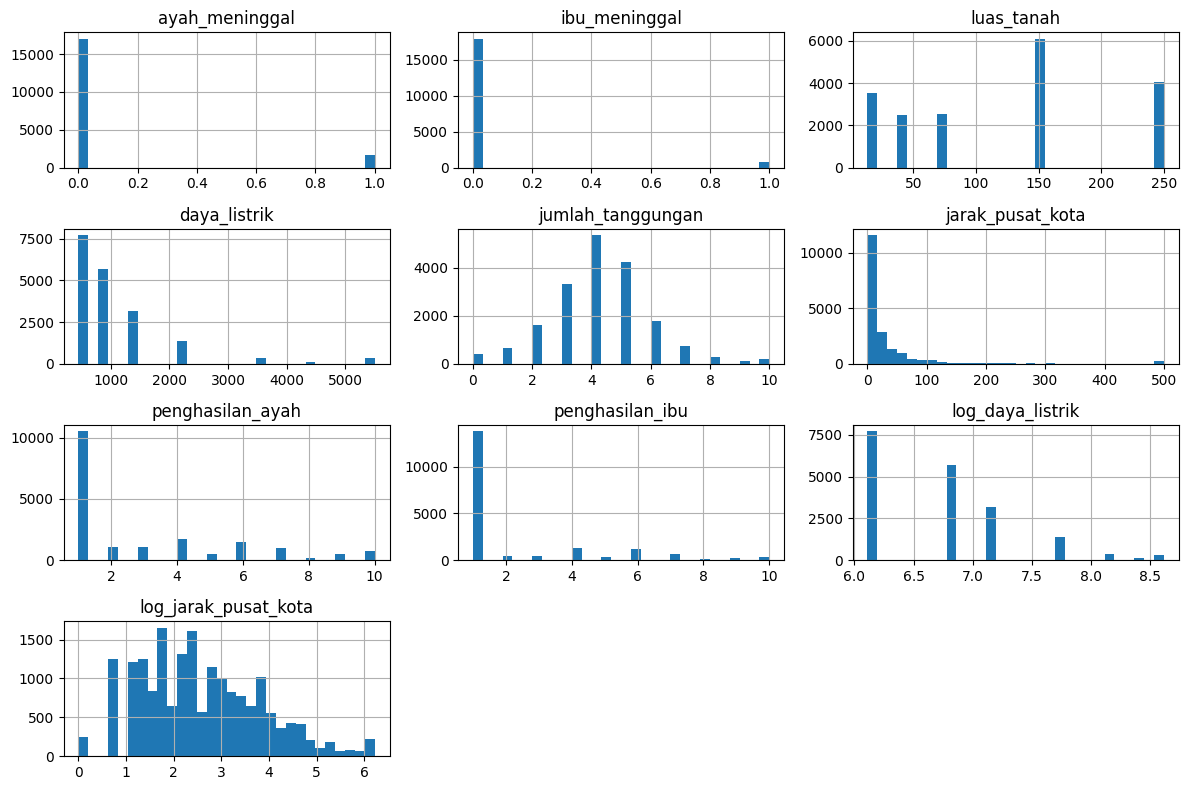


✅ Audit selesai. Jika semua hasil di atas stabil dan logis, data siap untuk preprocessing.


In [ ]:
final_audit(df_clean)


Kesimpulan
Dataset sudah bersih, lengkap, konsisten, dan siap preprocessing:

Tidak ada missing values/duplikat.

Outlier terkendali dengan winsorizing/log transform.

Tipe data sesuai.

Distribusi kategori masuk akal.



---



# PREPROCESSING DAN PCA

## PREPROCESSING

### Menggabungkan scaling numerik dan encoding kategorikal ke dalam satu transformasi, sehingga data bersih siap dipakai untuk PCA dan klustering UKT (JADI 135 KOLOM )

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Numerik asli (tanpa ayah/ibu meninggal)
num_cols = ['luas_tanah','jumlah_tanggungan','penghasilan_ayah','penghasilan_ibu',
            'log_daya_listrik','log_jarak_pusat_kota']

# Ambil semua kolom object + tambahkan ayah/ibu meninggal
cat_cols = df_clean.select_dtypes(include='object').columns.tolist()
cat_cols += ['ayah_meninggal','ibu_meninggal']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
    ]
)

X = preprocessor.fit_transform(df_clean)


In [ ]:
print("Bentuk data setelah preprocessing:", X.shape)


Bentuk data setelah preprocessing: (18722, 135)




---



### MENAMPILKAN hasil DataFrame dari data yang sudah diproses.

In [ ]:
import pandas as pd

# Ambil nama kolom hasil transformasi
num_features = num_cols
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)

all_features = list(num_features) + list(cat_features)

# Ubah ke DataFrame biar lebih mudah dibaca
df_preprocessed = pd.DataFrame(X.toarray() if hasattr(X, "toarray") else X,
                               columns=all_features)

print(df_preprocessed.head())


   luas_tanah  jumlah_tanggungan  penghasilan_ayah  penghasilan_ibu  \
0    0.340380          -0.089847          2.662256        -0.519803   
1   -0.543832          -0.089847          2.662256         3.106541   
2   -1.258228           0.494223         -0.704310        -0.519803   
3   -0.977154           1.078293         -0.704310        -0.519803   
4   -0.543832           0.494223          2.288193         3.559834   

   log_daya_listrik  log_jarak_pusat_kota  jenjang_S1  jenjang_S2  jenjang_S3  \
0          0.745230             -0.940966         1.0         0.0         0.0   
1          1.600701             -0.074998         1.0         0.0         0.0   
2          0.147477              0.673103         1.0         0.0         0.0   
3          0.147477             -0.011905         1.0         0.0         0.0   
4          1.600701              0.768764         1.0         0.0         0.0   

   jenjang_Sp-1  ...  transportasi_asal_Kendaraan Darat  \
0           0.0  ...       

**Kesimpulan**
Data hasil preprocessing ini sudah siap untuk tahap PCA dan klustering UKT.

Standardisasi membuat variabel numerik seimbang, sehingga tidak ada yang mendominasi hanya karena skala besar.

One‑Hot Encoding membuat variabel kategorikal bisa ikut dianalisis secara matematis.



---



### MENAMPILKAN daftar lengkap nama kolom hasil preprocessing.

In [ ]:
import pandas as pd

# Ambil nama kolom numerik (tetap sama)
num_features = num_cols

# Ambil nama kolom kategorikal hasil OneHotEncoder
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)

# Gabungkan semua nama kolom
all_features = list(num_features) + list(cat_features)

# Ubah hasil X ke DataFrame dengan nama kolom baru
df_preprocessed = pd.DataFrame(X.toarray() if hasattr(X, "toarray") else X,
                               columns=all_features)

# Tampilkan daftar semua kolom baru
print("Jumlah kolom:", len(df_preprocessed.columns))
print("Daftar kolom baru:")
print(df_preprocessed.columns.tolist())


Jumlah kolom: 135
Daftar kolom baru:
['luas_tanah', 'jumlah_tanggungan', 'penghasilan_ayah', 'penghasilan_ibu', 'log_daya_listrik', 'log_jarak_pusat_kota', 'jenjang_S1', 'jenjang_S2', 'jenjang_S3', 'jenjang_Sp-1', 'prodi_AGROBISNIS PERIKANAN', 'prodi_AGRONOMI', 'prodi_AGROTEKNOLOGI', 'prodi_AKUNTANSI', 'prodi_ANESTESIOLOGI DAN TERAPI INTENSIF', 'prodi_ANTROPOLOGI SOSIAL', 'prodi_ARSITEKTUR', 'prodi_BIOLOGI', 'prodi_BUDIDAYA PERAIRAN', 'prodi_EKONOMI PEMBANGUNAN', 'prodi_ENTOMOLOGI', 'prodi_FARMASI', 'prodi_FISIKA', 'prodi_ILMU ADMINISTRASI BISNIS', 'prodi_ILMU ADMINISTRASI NEGARA', 'prodi_ILMU BEDAH', 'prodi_ILMU EKONOMI', 'prodi_ILMU HUKUM', 'prodi_ILMU KEBIDANAN DAN PENYAKIT KANDUNGAN', 'prodi_ILMU KEDOKTERAN FISIK DAN REHABILITASI', 'prodi_ILMU KEHUTANAN', 'prodi_ILMU KELAUTAN', 'prodi_ILMU KEPERAWATAN', 'prodi_ILMU KESEHATAN ANAK', 'prodi_ILMU KESEHATAN MASYARAKAT', 'prodi_ILMU KOMUNIKASI', 'prodi_ILMU LINGUISTIK', 'prodi_ILMU MANAJEMEN', 'prodi_ILMU PANGAN', 'prodi_ILMU PEMERINTAH

TOTAL ADA 135 KOLOM



---



### VERIFIKASI untuk memastikan hasil preprocessing:



In [ ]:
import pandas as pd

# --- Ambil kolom numerik ---
numeric_cols = df_preprocessed.select_dtypes(include=['int64','float64']).columns.tolist()
print("total kolom numerik :", len(numeric_cols))
print("nama nama kolom numerik :")
for col in numeric_cols:
    print("-", col)

# --- Ambil kolom kategorikal ---
categorical_cols = df_preprocessed.select_dtypes(exclude=['int64','float64']).columns.tolist()
print("\n\ntotal kolom kategorikal :", len(categorical_cols))
print("nama nama kolom kategorikal :")
for col in categorical_cols:
    print("-", col)


total kolom numerik : 135
nama nama kolom numerik :
- luas_tanah
- jumlah_tanggungan
- penghasilan_ayah
- penghasilan_ibu
- log_daya_listrik
- log_jarak_pusat_kota
- jenjang_S1
- jenjang_S2
- jenjang_S3
- jenjang_Sp-1
- prodi_AGROBISNIS PERIKANAN
- prodi_AGRONOMI
- prodi_AGROTEKNOLOGI
- prodi_AKUNTANSI
- prodi_ANESTESIOLOGI DAN TERAPI INTENSIF
- prodi_ANTROPOLOGI SOSIAL
- prodi_ARSITEKTUR
- prodi_BIOLOGI
- prodi_BUDIDAYA PERAIRAN
- prodi_EKONOMI PEMBANGUNAN
- prodi_ENTOMOLOGI
- prodi_FARMASI
- prodi_FISIKA
- prodi_ILMU ADMINISTRASI BISNIS
- prodi_ILMU ADMINISTRASI NEGARA
- prodi_ILMU BEDAH
- prodi_ILMU EKONOMI
- prodi_ILMU HUKUM
- prodi_ILMU KEBIDANAN DAN PENYAKIT KANDUNGAN
- prodi_ILMU KEDOKTERAN FISIK DAN REHABILITASI
- prodi_ILMU KEHUTANAN
- prodi_ILMU KELAUTAN
- prodi_ILMU KEPERAWATAN
- prodi_ILMU KESEHATAN ANAK
- prodi_ILMU KESEHATAN MASYARAKAT
- prodi_ILMU KOMUNIKASI
- prodi_ILMU LINGUISTIK
- prodi_ILMU MANAJEMEN
- prodi_ILMU PANGAN
- prodi_ILMU PEMERINTAHAN
- prodi_ILMU PENYAKIT



---



### MENGECEK distribusi nilai tiap kolom (135 kolom)

In [ ]:
import pandas as pd

# Ambil nama kolom hasil transformasi
num_features = num_cols
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)
all_features = list(num_features) + list(cat_features)

# Ubah hasil X ke DataFrame
df_preprocessed = pd.DataFrame(X.toarray() if hasattr(X, "toarray") else X,
                               columns=all_features)

# Loop setiap kolom dan tampilkan jumlah tiap nilai unik
for col in df_preprocessed.columns:
    print(f"\nDistribusi nilai di kolom: {col}")
    print(df_preprocessed[col].value_counts())



Distribusi nilai di kolom: luas_tanah
luas_tanah
 0.340380    6105
 1.511522    4076
-1.258228    3534
-0.543832    2539
-0.977154    2468
Name: count, dtype: int64

Distribusi nilai di kolom: jumlah_tanggungan
jumlah_tanggungan
-0.089847    5359
 0.494223    4219
-0.673918    3324
 1.078293    1789
-1.257988    1598
 1.662364     754
-1.842059     641
-2.426129     426
 2.246434     287
 3.414575     195
 2.830505     130
Name: count, dtype: int64

Distribusi nilai di kolom: penghasilan_ayah
penghasilan_ayah
-0.704310    10521
 0.417879     1700
 1.166004     1448
-0.330247     1098
 0.043816     1097
 1.540067      979
 2.662256      749
 2.288193      468
 0.791942      458
 1.914130      204
Name: count, dtype: int64

Distribusi nilai di kolom: penghasilan_ibu
penghasilan_ibu
-0.519803    13805
 0.840076     1305
 1.746662     1200
 2.199955      611
 0.386783      463
-0.066510      392
 3.559834      306
 1.293369      297
 3.106541      227
 2.653248      116
Name: count, dtype



---



### Mengetahui nama semua fitur hasil preprocessing.

penting untuk:

Membuat DataFrame dengan label kolom yang jelas.

Memeriksa apakah semua kategori sudah ter‑encode.

Menyambungkan hasil preprocessing ke tahap PCA atau klustering dengan interpretasi yang lebih mudah.

In [ ]:
feature_names = preprocessor.get_feature_names_out()


### MENGURANGI dimensi data dengan PCA menjadi hanya 2 komponen utama.

Visualisasi (scatter plot PC1 vs PC2 untuk melihat pola atau klaster).

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)




---



### PCA untuk reduksi dimensi + visualisasi distribusi mahasiswa dalam ruang 2D

🔽 Digunakan untuk mereduksi dimensi data dari ratusan kolom menjadi hanya 2 komponen utama (PC1 dan PC2). Hasilnya adalah koordinat baru (X_pca) yang mewakili setiap mahasiswa dalam ruang 2 dimensi.

In [ ]:
from sklearn.decomposition import PCA

# PCA dengan 2 komponen utama
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

print("Explained variance ratio:", pca.explained_variance_ratio_)


Explained variance ratio: [0.20977272 0.08115335]




---



🔽 Membuat scatter plot dari hasil PCA.

Sumbu X = PC1, sumbu Y = PC2.

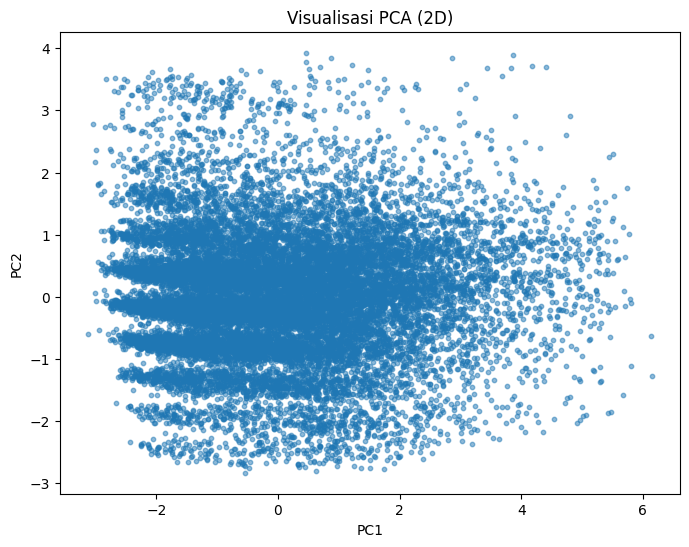

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.5, s=10)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Visualisasi PCA (2D)")
plt.show()




---



### PCA dengan 10 komponen utama

In [ ]:
pca = PCA(n_components=10)
pca.fit(X)
print(pca.explained_variance_ratio_)
print("Total explained:", pca.explained_variance_ratio_.sum())


[0.20977272 0.08115335 0.07328375 0.06415503 0.05769915 0.04089802
 0.03808117 0.02988526 0.02853824 0.02710021]
Total explained: 0.6505669079425648


🔼 Kesimpulan HASIL DI ATAS

PCA berhasil mereduksi data kompleks menjadi 10 dimensi yang tetap representatif.

PC1–PC5 menangkap pola besar (ekonomi, tanggungan, jarak kota), sedangkan PC6–PC10 menambahkan detail sosial dan fasilitas rumah.

Dengan 65% variansi terjelaskan, hasil ini cukup stabil untuk klustering UKT, karena pola utama sudah tercakup tanpa kehilangan terlalu banyak informasi.



---



🔽 VISUALISASINYA 🔽

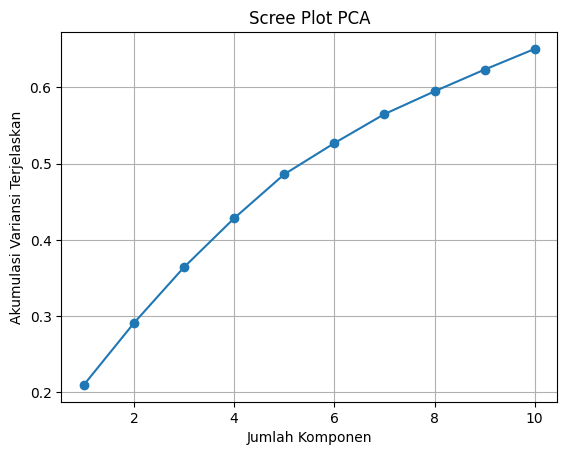

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1, 11), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel("Jumlah Komponen")
plt.ylabel("Akumulasi Variansi Terjelaskan")
plt.title("Scree Plot PCA")
plt.grid(True)
plt.show()




---



## SILHOUETTE SCORE

cek nilai silhoette score kalau 2 kluster

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Jalankan KMeans di ruang PCA 10D
X_pca_10 = pca.transform(X)
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_pca_10)

# Hitung silhouette score
score = silhouette_score(X_pca_10, clusters)
print("Silhouette Score:", score)


Silhouette Score: 0.20689594163166974


### PENCARIAN KLUSTER TERBAIK DARI 2 - 10

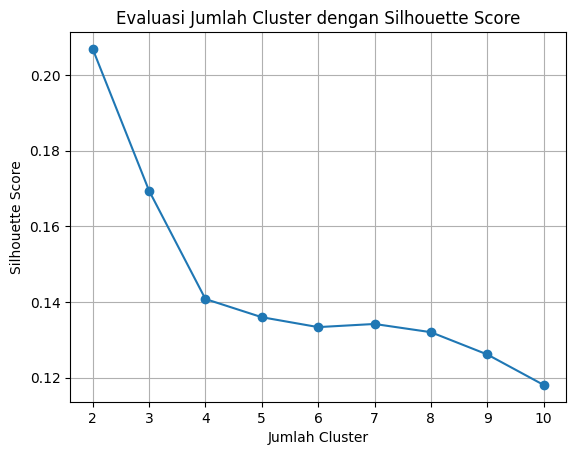

In [ ]:
scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(X_pca_10)
    score = silhouette_score(X_pca_10, clusters)
    scores.append(score)

plt.plot(range(2, 11), scores, marker='o')
plt.xlabel("Jumlah Cluster")
plt.ylabel("Silhouette Score")
plt.title("Evaluasi Jumlah Cluster dengan Silhouette Score")
plt.grid(True)
plt.show()


🔽 SILHOETTE SCORE KLUSTER 1 - 10

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

X_pca_10 = pca.transform(X)

for k in range(2, 12):  # dari 2 sampai 11
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(X_pca_10)
    score = silhouette_score(X_pca_10, clusters)
    print(f"Cluster {k}: Silhouette Score = {score:.4f}")


Cluster 2: Silhouette Score = 0.2069
Cluster 3: Silhouette Score = 0.1694
Cluster 4: Silhouette Score = 0.1408
Cluster 5: Silhouette Score = 0.1360
Cluster 6: Silhouette Score = 0.1334
Cluster 7: Silhouette Score = 0.1342
Cluster 8: Silhouette Score = 0.1320
Cluster 9: Silhouette Score = 0.1261
Cluster 10: Silhouette Score = 0.1181
Cluster 11: Silhouette Score = 0.1174




---



### Visualisasi hasil klasterisasi KMeans setelah reduksi dimensi dengan PCA

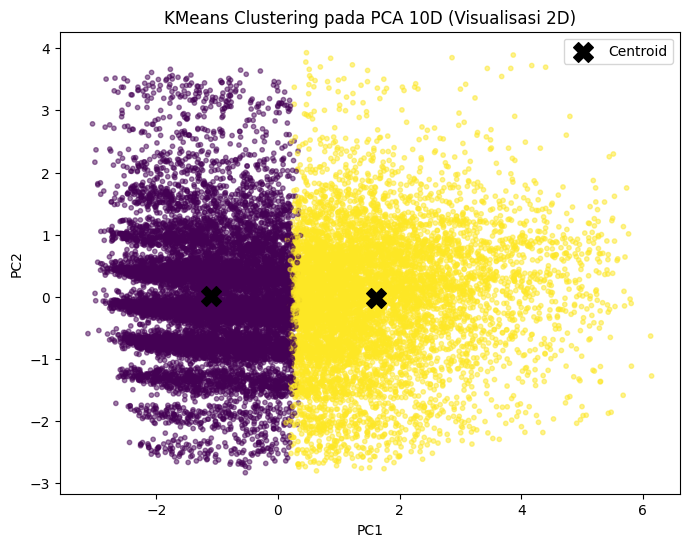

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Jalankan KMeans di ruang PCA 10D
X_pca_10 = pca.transform(X)
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_pca_10)

# Visualisasi hasil clustering di ruang PCA 2D
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap='viridis', alpha=0.5, s=10)

# Centroid: ambil hanya 2 dimensi pertama
centroids_2d = kmeans.cluster_centers_[:, :2]
plt.scatter(centroids_2d[:,0], centroids_2d[:,1], c='black', marker='X', s=200, label='Centroid')

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("KMeans Clustering pada PCA 10D (Visualisasi 2D)")
plt.legend()
plt.show()


Grafik ini menunjukkan bagaimana mahasiswa terbagi ke dalam 2 klaster berdasarkan profil sosial‑ekonomi mereka.

Warna berbeda menandakan kelompok yang terbentuk, sedangkan tanda X hitam menunjukkan pusat klaster.



---



###  REPRESENTASI ringkas dari data kompleks (133 fitur → 10 komponen).

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA

# Misalnya X adalah hasil preprocessing (18722 x 133)
pca = PCA(n_components=10, random_state=42)
X_pca = pca.fit_transform(X)

# Ubah ke DataFrame dengan nama kolom PC1–PC10
df_pca = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(10)])

# Tampilkan 10 baris pertama
print(df_pca.head(10))


        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  2.124049  0.505206 -1.006979  0.031725  1.718831 -1.186012 -0.055412   
1  3.730433  0.506289  1.908009 -1.846217  0.791496 -0.251950 -0.050579   
2 -1.635615  0.610897  0.182599 -0.713130  0.590516  0.628905  1.005991   
3 -0.666990  1.008070 -0.543650 -0.723098  0.334525  0.947810  0.162288   
4  3.025680  1.211818  3.102581 -1.775313  0.359170 -0.136708  0.803970   
5  0.157696  0.602430 -0.839457 -0.765479  0.088638  0.146056  0.599187   
6  1.983795 -0.353897  1.310934 -1.178641  0.276882  0.074274 -0.608451   
7  3.432350  1.189563  1.302330 -0.979915  0.706016 -0.540805  1.116343   
8  3.146716  1.206099  1.593691 -0.664187  0.993438 -0.349593  0.820416   
9  1.114696  2.078092  1.693790 -0.453808 -0.486155 -0.804002  0.557447   

        PC8       PC9      PC10  
0  0.754017 -0.248055  0.125289  
1 -0.371139 -0.721207  0.276381  
2  0.308372 -0.447761 -0.275284  
3 -0.670352  0.586885 -0.280601  
4 -0

In [ ]:
print(pca.explained_variance_ratio_)
print("Total variansi yang dijelaskan:", pca.explained_variance_ratio_.sum())


[0.20977272 0.08115335 0.07328375 0.06415503 0.05769915 0.04089802
 0.03808117 0.02988526 0.02853824 0.02710021]
Total variansi yang dijelaskan: 0.6505669079425648


PC1 = 20.9% → komponen pertama menangkap informasi terbesar

PC2 = 8.1%, PC3 = 7.3%, PC4 = 6.4%, PC5 = 5.7%

PC6–PC10 masing‑masing menjelaskan 2–4% variansi, lebih fokus pada detail kecil

Total explained = 65% → artinya 10 komponen ini sudah merangkum sekitar dua pertiga informasi asli dari 133 fitur.



---



### Fitur utama pembentuk PC1–PC10.

In [ ]:
import pandas as pd

# Ambil loading matrix dari PCA
loadings = pca.components_

# Ambil nama fitur dari preprocessor
feature_names = preprocessor.get_feature_names_out()

# Buat DataFrame
df_loadings = pd.DataFrame(loadings.T,
                           index=feature_names,
                           columns=[f"PC{i+1}" for i in range(10)])

# Tampilkan 10 fitur teratas untuk setiap PC
for i in range(10):
    print(f"\nTop 10 fitur pembentuk PC{i+1}:")
    print(df_loadings.iloc[:, i].sort_values(ascending=False).head(10))



Top 10 fitur pembentuk PC1:
num__log_daya_listrik                            0.485671
num__penghasilan_ayah                            0.456047
num__penghasilan_ibu                             0.397144
num__luas_tanah                                  0.335966
cat__bahan_lantai_Keramik Biasa                  0.140532
cat__bahan_tembok_Semen Beton                    0.126524
cat__rencana_tinggal_Bersama keluarga/kenalan    0.107911
cat__mck_Kepemilikan sendiri di dalam            0.079457
cat__id_pekerjaan_ibu_5                          0.076395
cat__sumber_air_PDAM                             0.075511
Name: PC1, dtype: float64

Top 10 fitur pembentuk PC2:
num__jumlah_tanggungan                                       0.960571
num__penghasilan_ayah                                        0.172453
cat__transportasi_asal_Pesawat Terbang                       0.076962
cat__rencana_tinggal_Kos/Sewa                                0.068298
num__log_daya_listrik                                   

🔹 PC1 – Kapasitas Ekonomi Rumah Tangga
Dominan: daya listrik, penghasilan ayah/ibu, luas tanah, bahan lantai/tembok, sumber air PDAM.

Makna: PC1 merepresentasikan tingkat kesejahteraan fisik-ekonomi keluarga. Semakin tinggi skor PC1, semakin besar daya listrik, penghasilan, dan kualitas rumah.

🔹 PC2 – Beban Tanggungan & Mobilitas
Dominan: jumlah tanggungan, penghasilan ayah, transportasi pesawat, kos/sewa.

Makna: PC2 menangkap beban keluarga (jumlah tanggungan) dan mobilitas/akses transportasi. Mahasiswa dengan skor tinggi mungkin berasal dari keluarga besar dengan mobilitas tinggi.

🔹 PC3 – Lokasi & Peran Ibu
Dominan: jarak ke pusat kota, penghasilan ibu, pekerjaan ibu, kos/sewa.

Makna: PC3 menyoroti akses geografis (urban vs rural) dan kontribusi ekonomi ibu. Skor tinggi bisa berarti tinggal jauh dari kota tapi ibu berperan besar secara finansial.

🔹 PC4 – Aset Tanah & Lokasi
Dominan: luas tanah, jarak ke pusat kota, sumber air sumur.

Makna: PC4 merepresentasikan aset properti (tanah) dan konteks geografis. Skor tinggi = kepemilikan tanah luas, biasanya di daerah lebih jauh dari pusat kota.

🔹 PC5 – Ekonomi Ayah & Infrastruktur
Dominan: penghasilan ayah, jarak kota, daya listrik, pekerjaan ibu/ayah.

Makna: PC5 menekankan peran ayah sebagai sumber utama ekonomi, ditambah faktor infrastruktur rumah tangga.

🔹 PC6 – Daya Listrik & Kondisi Keluarga
Dominan: daya listrik, jarak kota, jumlah tanggungan, status ayah meninggal.

Makna: PC6 menangkap kondisi keluarga (ayah meninggal, tanggungan banyak) dengan indikator daya listrik sebagai proxy kesejahteraan.

🔹 PC7 – Pola Tinggal & Transportasi
Dominan: kos/sewa, transportasi pesawat, sumber air PDAM, daya listrik.

Makna: PC7 menyoroti pola tinggal mahasiswa (kos/sewa vs bersama keluarga) dan akses transportasi modern.

🔹 PC8 – Sumber Air & Material Rumah
Dominan: sumber air sumur, bahan tembok kayu, lantai semen plester, mck luar.

Makna: PC8 merepresentasikan kualitas infrastruktur rumah tangga (air, bahan bangunan, sanitasi).

🔹 PC9 – Kualitas Rumah & Pola Tinggal
Dominan: bahan tembok semen, lantai keramik, sumber air sumur, kos/sewa.

Makna: PC9 menyoroti kualitas fisik rumah dan pola tinggal mahasiswa (kos/sewa).

🔹 PC10 – Kepemilikan Rumah & Transportasi Umum
Dominan: rumah milik bersama keluarga, transportasi umum, daya listrik.

Makna: PC10 menangkap kepemilikan rumah tidak mandiri (milik bersama) dan ketergantungan pada transportasi umum.

✨ Kesimpulan Besar
PC1–PC5 lebih banyak menangkap dimensi ekonomi inti (penghasilan, daya listrik, tanah, pekerjaan orang tua).

PC6–PC10 lebih banyak menangkap dimensi sosial-infrastruktur (pola tinggal, transportasi, sumber air, kualitas rumah).



---



### HEATMAP untuk melihat fitur mana yang paling berpengaruh terhadap tiap komponen PCA.

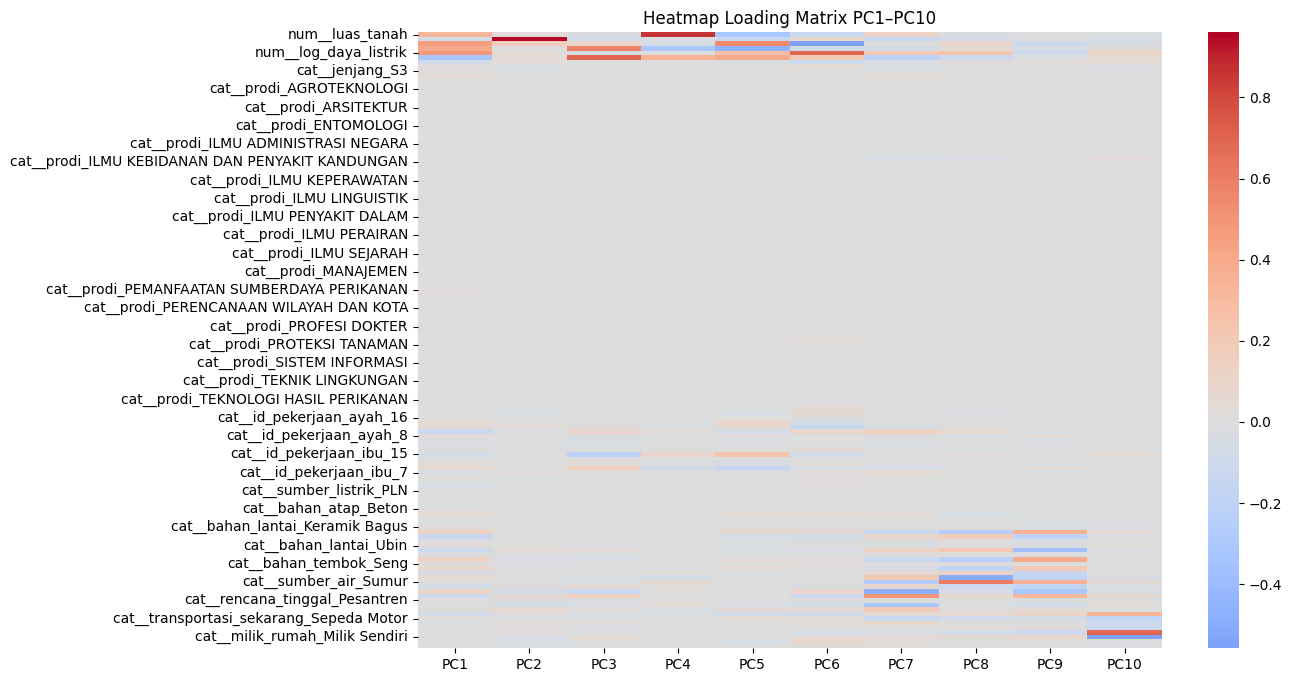

In [ ]:
import seaborn as sns

plt.figure(figsize=(12,8))
sns.heatmap(df_loadings.iloc[:, :10], cmap="coolwarm", center=0)
plt.title("Heatmap Loading Matrix PC1–PC10")
plt.show()


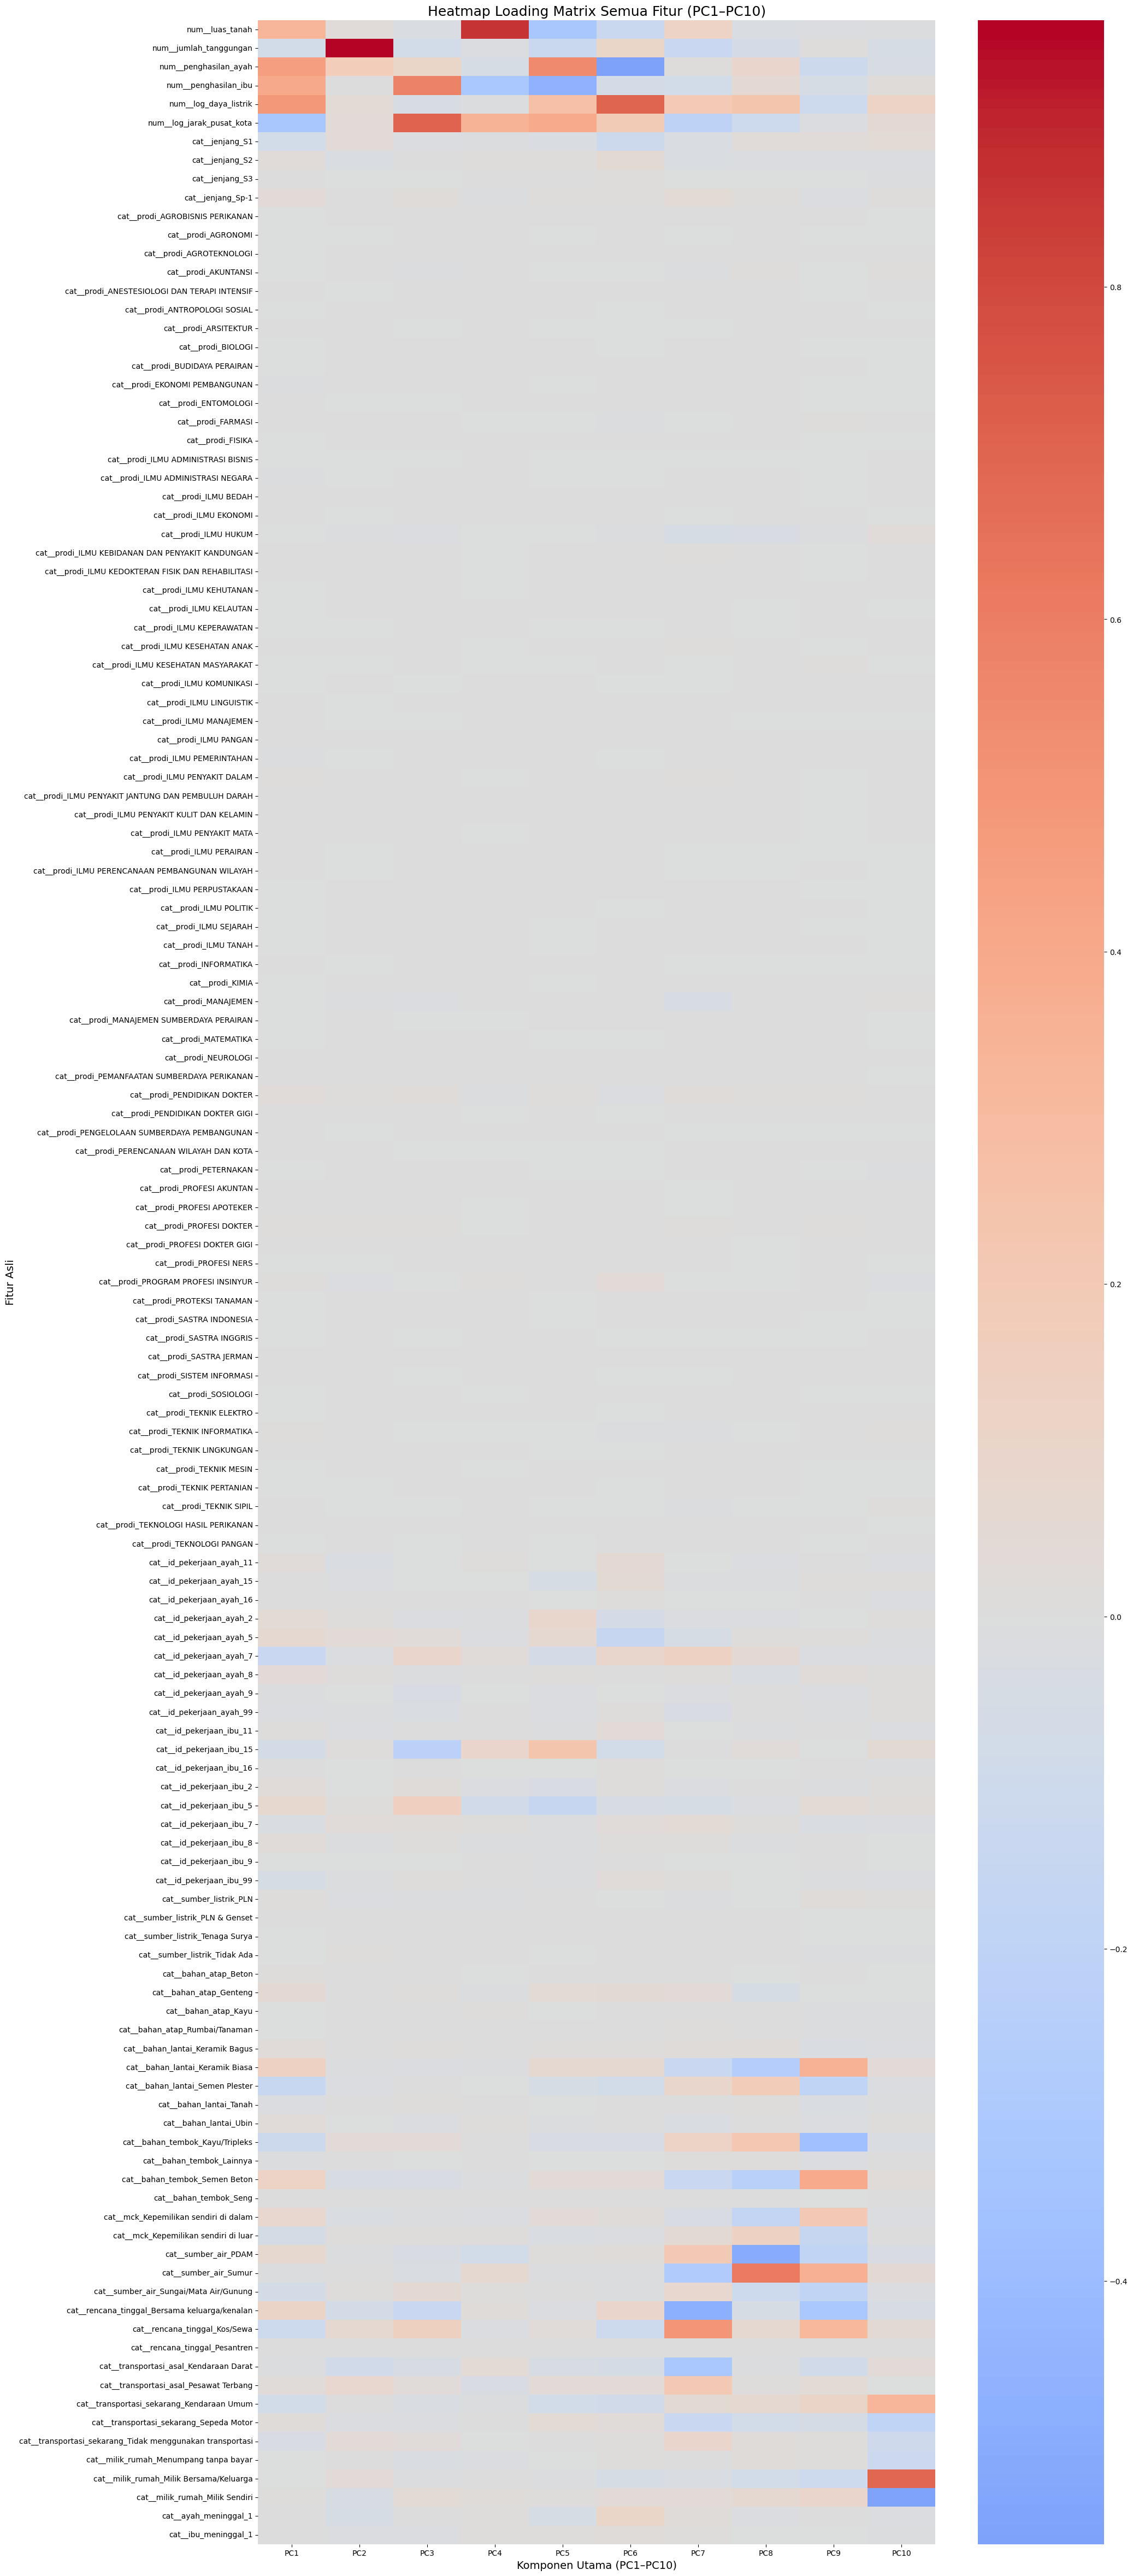

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ambil loading matrix dari PCA
loadings = pca.components_

# Ambil nama fitur dari preprocessor
feature_names = preprocessor.get_feature_names_out()

# Buat DataFrame
df_loadings = pd.DataFrame(loadings.T,
                           index=feature_names,
                           columns=[f"PC{i+1}" for i in range(10)])

# Plot heatmap besar
plt.figure(figsize=(20, 60))  # ukuran besar agar semua fitur terbaca
sns.heatmap(df_loadings, cmap="coolwarm", center=0, annot=False)
plt.title("Heatmap Loading Matrix Semua Fitur (PC1–PC10)", fontsize=18)
plt.xlabel("Komponen Utama (PC1–PC10)", fontsize=14)
plt.ylabel("Fitur Asli", fontsize=14)
plt.show()




---



### 🔽 MENAMPILKAN Seberapa besar informasi (variansi) yang ditangkap oleh masing‑masing komponen utama (PC1–PC10).

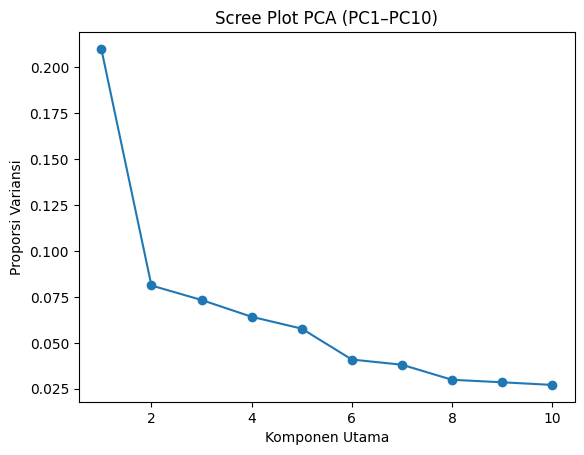

In [ ]:
plt.plot(range(1, 11), pca.explained_variance_ratio_, marker="o")
plt.title("Scree Plot PCA (PC1–PC10)")
plt.xlabel("Komponen Utama")
plt.ylabel("Proporsi Variansi")
plt.show()




---



### VISUALISASI hasil klasterisasi KMeans di ruang PCA 2D DAN 3D

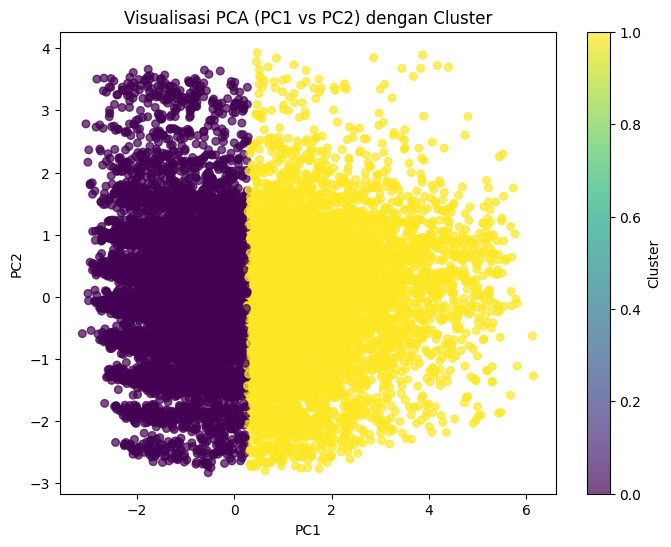

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# PCA reduksi ke 2 komponen utama untuk visualisasi
pca_vis = PCA(n_components=2, random_state=42)
X_pca_vis = pca_vis.fit_transform(X)

# Clustering dengan KMeans
kmeans = KMeans(n_clusters=2, random_state=42, n_init="auto")
clusters = kmeans.fit_predict(X_pca_vis)

# Plot hasil PCA dengan warna sesuai cluster
plt.figure(figsize=(8,6))
plt.scatter(X_pca_vis[:,0], X_pca_vis[:,1], c=clusters, cmap='viridis', s=30, alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Visualisasi PCA (PC1 vs PC2) dengan Cluster")
plt.colorbar(label="Cluster")
plt.show()


In [ ]:
kmeans = KMeans(n_clusters=2, random_state=42)


In [ ]:
clusters = kmeans.fit_predict(X_pca_10)
df_clean['cluster'] = clusters

# Cek jumlah anggota per cluster
import numpy as np
unique, counts = np.unique(clusters, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Cluster {u}: {c} mahasiswa")


Cluster 0: 11144 mahasiswa
Cluster 1: 7578 mahasiswa


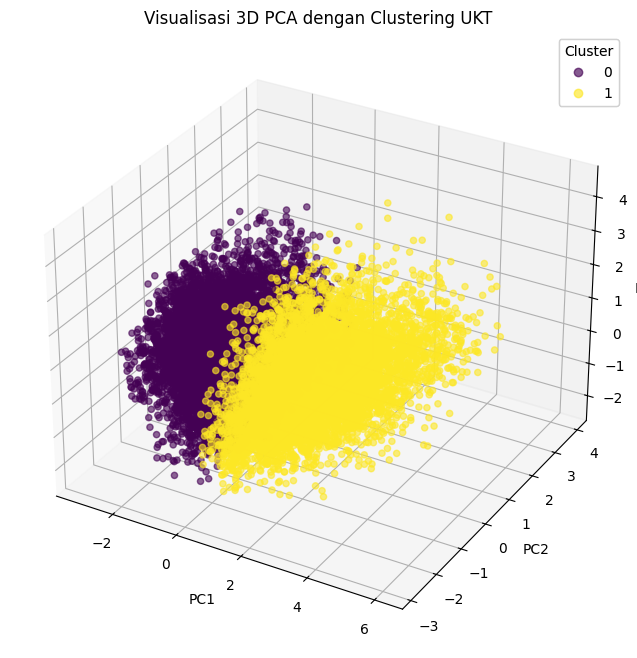

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- 1. PCA dengan 3 komponen untuk visualisasi 3D ---
pca3 = PCA(n_components=3)
X_pca3 = pca3.fit_transform(X)

# --- 2. KMeans clustering (misalnya 2 cluster untuk UKT) ---
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_pca3)

# --- 3. Visualisasi 3D ---
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_pca3[:,0], X_pca3[:,1], X_pca3[:,2],
                     c=clusters, cmap='viridis', alpha=0.6, s=20)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("Visualisasi 3D PCA dengan Clustering UKT")

# Tambahkan legend cluster
legend1 = ax.legend(*scatter.legend_elements(), title="Cluster")
ax.add_artist(legend1)

plt.show()


In [ ]:
df_preprocessed['cluster'] = clusters




---



### MENGANALISIS hasil clustering dengan cara membandingkan rata‑rata semua variabel numerik antar cluster.

In [ ]:
import pandas as pd

# Atur agar semua kolom ditampilkan
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)   # kalau mau semua baris juga
pd.set_option('display.width', None)      # biar tidak dipotong per baris
pd.set_option('display.max_colwidth', None)

# --- 1. Ambil semua fitur (133 kolom), kecuali cluster ---
all_features = df_preprocessed.drop(columns=['cluster']).columns.tolist()

# --- 2. Hitung rata-rata tiap kolom per cluster ---
cluster_summary = df_preprocessed.groupby('cluster')[all_features].mean().round(2)

print("📊 Ringkasan rata-rata semua 133 kolom per cluster:")
print(cluster_summary)

# --- 3. Jumlah anggota per cluster ---
cluster_counts = df_preprocessed['cluster'].value_counts()
print("\n👥 Jumlah mahasiswa per cluster:")
print(cluster_counts)

# --- 4. Perbandingan Cluster 0 vs 1 (semua kolom) ---
summary_compare = pd.DataFrame({
    'Cluster 0': cluster_summary.loc[0],
    'Cluster 1': cluster_summary.loc[1]
})
print("\n🔍 Perbandingan Cluster 0 vs Cluster 1 (semua kolom):")
print(summary_compare)


📊 Ringkasan rata-rata semua 133 kolom per cluster:
         luas_tanah  jumlah_tanggungan  penghasilan_ayah  penghasilan_ibu  \
cluster                                                                     
0             -0.36               0.09             -0.51            -0.40   
1              0.54              -0.14              0.75             0.59   

         log_daya_listrik  log_jarak_pusat_kota  jenjang_S1  jenjang_S2  \
cluster                                                                   
0                   -0.54                  0.34        0.96        0.02   
1                    0.80                 -0.50        0.73        0.10   

         jenjang_S3  jenjang_Sp-1  prodi_AGROBISNIS PERIKANAN  prodi_AGRONOMI  \
cluster                                                                         
0              0.00          0.00                        0.01            0.01   
1              0.02          0.06                        0.00            0.00   

         prodi

In [ ]:
import pandas as pd

# --- 1. Pilih indikator sosial ekonomi utama ---
indikator_cols = [
    'luas_tanah','penghasilan_ayah','penghasilan_ibu',
    'log_daya_listrik','log_jarak_pusat_kota','jumlah_tanggungan',
    'bahan_atap_Genteng','bahan_atap_Beton',
    'bahan_lantai_Keramik Bagus','bahan_lantai_Keramik Biasa',
    'bahan_tembok_Semen Beton',
    'sumber_air_PDAM','mck_Kepemilikan sendiri di dalam',
    'transportasi_asal_Pesawat Terbang',
    'milik_rumah_Milik Sendiri'
]

# --- 2. Hitung rata-rata tiap indikator per cluster ---
cluster_summary = df_preprocessed.groupby('cluster')[indikator_cols].mean()

# --- 3. Hitung skor sosial ekonomi cluster (jumlah rata-rata indikator) ---
cluster_summary['socio_score'] = cluster_summary.sum(axis=1)

# --- 4. Tampilkan hasil ---
print("📊 Rata-rata indikator sosial ekonomi per cluster:")
print(cluster_summary)

print("\n🔍 Skor sosial ekonomi per cluster:")
print(cluster_summary['socio_score'])


📊 Rata-rata indikator sosial ekonomi per cluster:
         luas_tanah  penghasilan_ayah  penghasilan_ibu  log_daya_listrik  \
cluster                                                                    
0         -0.364616         -0.508013        -0.401333         -0.542909   
1          0.535956          0.746738         0.589928          0.798033   

         log_jarak_pusat_kota  jumlah_tanggungan  bahan_atap_Genteng  \
cluster                                                                
0                    0.336988           0.092734            0.092533   
1                   -0.495346          -0.136311            0.222164   

         bahan_atap_Beton  bahan_lantai_Keramik Bagus  \
cluster                                                 
0                0.006462                    0.002513   
1                0.023483                    0.059235   

         bahan_lantai_Keramik Biasa  bahan_tembok_Semen Beton  \
cluster                                                       

### MENAMPILKAN CHART Distribusi Mahasiswa per Cluster

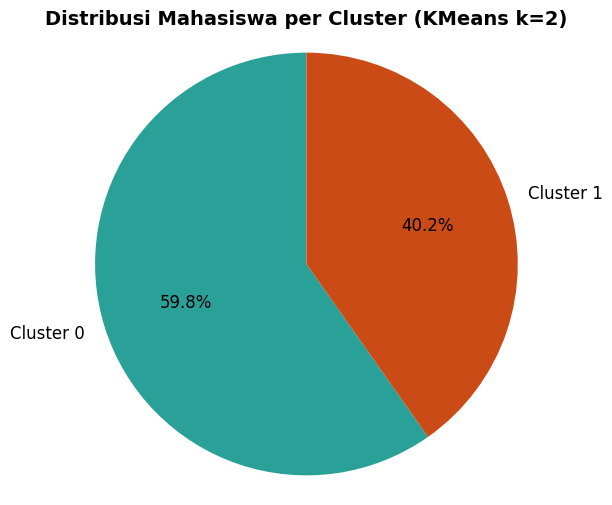

In [ ]:
import matplotlib.pyplot as plt

# Data jumlah mahasiswa per cluster
cluster_counts = [11187, 7535]
cluster_labels = ['Cluster 0', 'Cluster 1']
colors = ['#2aa198', '#cb4b16']  # teal vs orange

# Buat pie chart
plt.figure(figsize=(6,6))
plt.pie(cluster_counts, labels=cluster_labels, autopct='%1.1f%%',
        startangle=90, colors=colors, textprops={'fontsize':12})

plt.title("Distribusi Mahasiswa per Cluster (KMeans k=2)", fontsize=14, fontweight='bold')
plt.axis('equal')  # supaya pie chart bulat
plt.show()


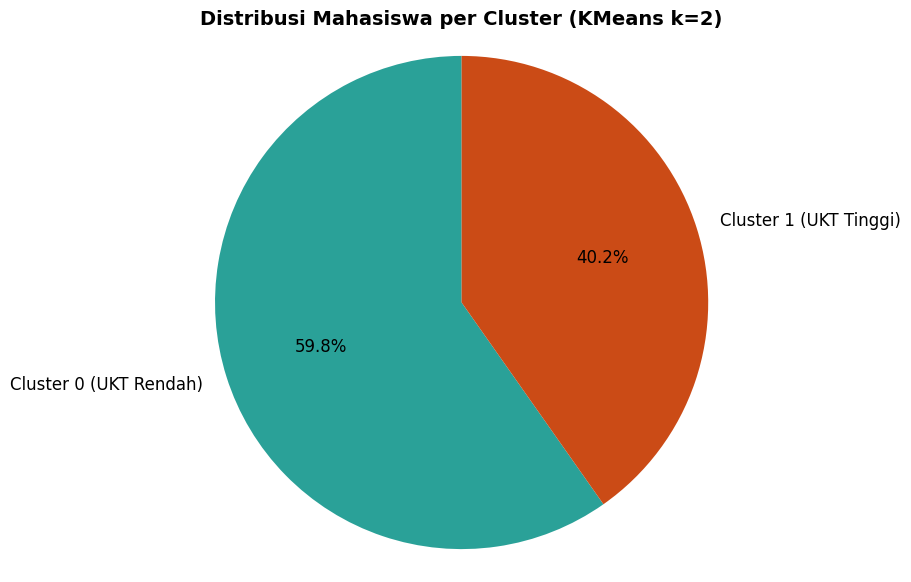

In [ ]:
import matplotlib.pyplot as plt

# Data jumlah mahasiswa per cluster
cluster_counts = [11187, 7535]
cluster_labels = ['Cluster 0 (UKT Rendah)', 'Cluster 1 (UKT Tinggi)']
colors = ['#2aa198', '#cb4b16']  # teal untuk rendah, orange untuk tinggi

# Buat pie chart
plt.figure(figsize=(7,7))
plt.pie(cluster_counts, labels=cluster_labels, autopct='%1.1f%%',
        startangle=90, colors=colors, textprops={'fontsize':12})

plt.title("Distribusi Mahasiswa per Cluster (KMeans k=2)", fontsize=14, fontweight='bold')
plt.axis('equal')  # supaya pie chart bulat
plt.show()


# STREAMLIT

In [ ]:
!pip install streamlit
!npm install -g localtunnel


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 87.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 84.3 MB/s eta 0:00:00
⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹
added 22 packages in 3s
⠹
⠹3 packages are looking for funding
⠹  run `npm fund` for details
⠹

In [ ]:
!curl ifconfig.me

35.198.253.111

In [ ]:
!streamlit run streamlit_app.py & npx localtunnel --port 8501


⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇Usage: streamlit run [OPTIONS] [TARGET] [ARGS]...
Try 'streamlit run --help' for help.

Error: Invalid value: File does not exist: streamlit_app.py
⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙your url is: https://early-months-slide.loca.lt
^C
